In [1]:
# Import statements
import os
import sys
import numpy as np
sys.argv = [""] # Hack to make argparse work in jupyter
if os.getcwd().endswith("classification"):
    os.chdir("..") # Fix working directory for imports
import aug_viewer

100%|██████████| 4/4 [00:00<00:00, 1690.40it/s]


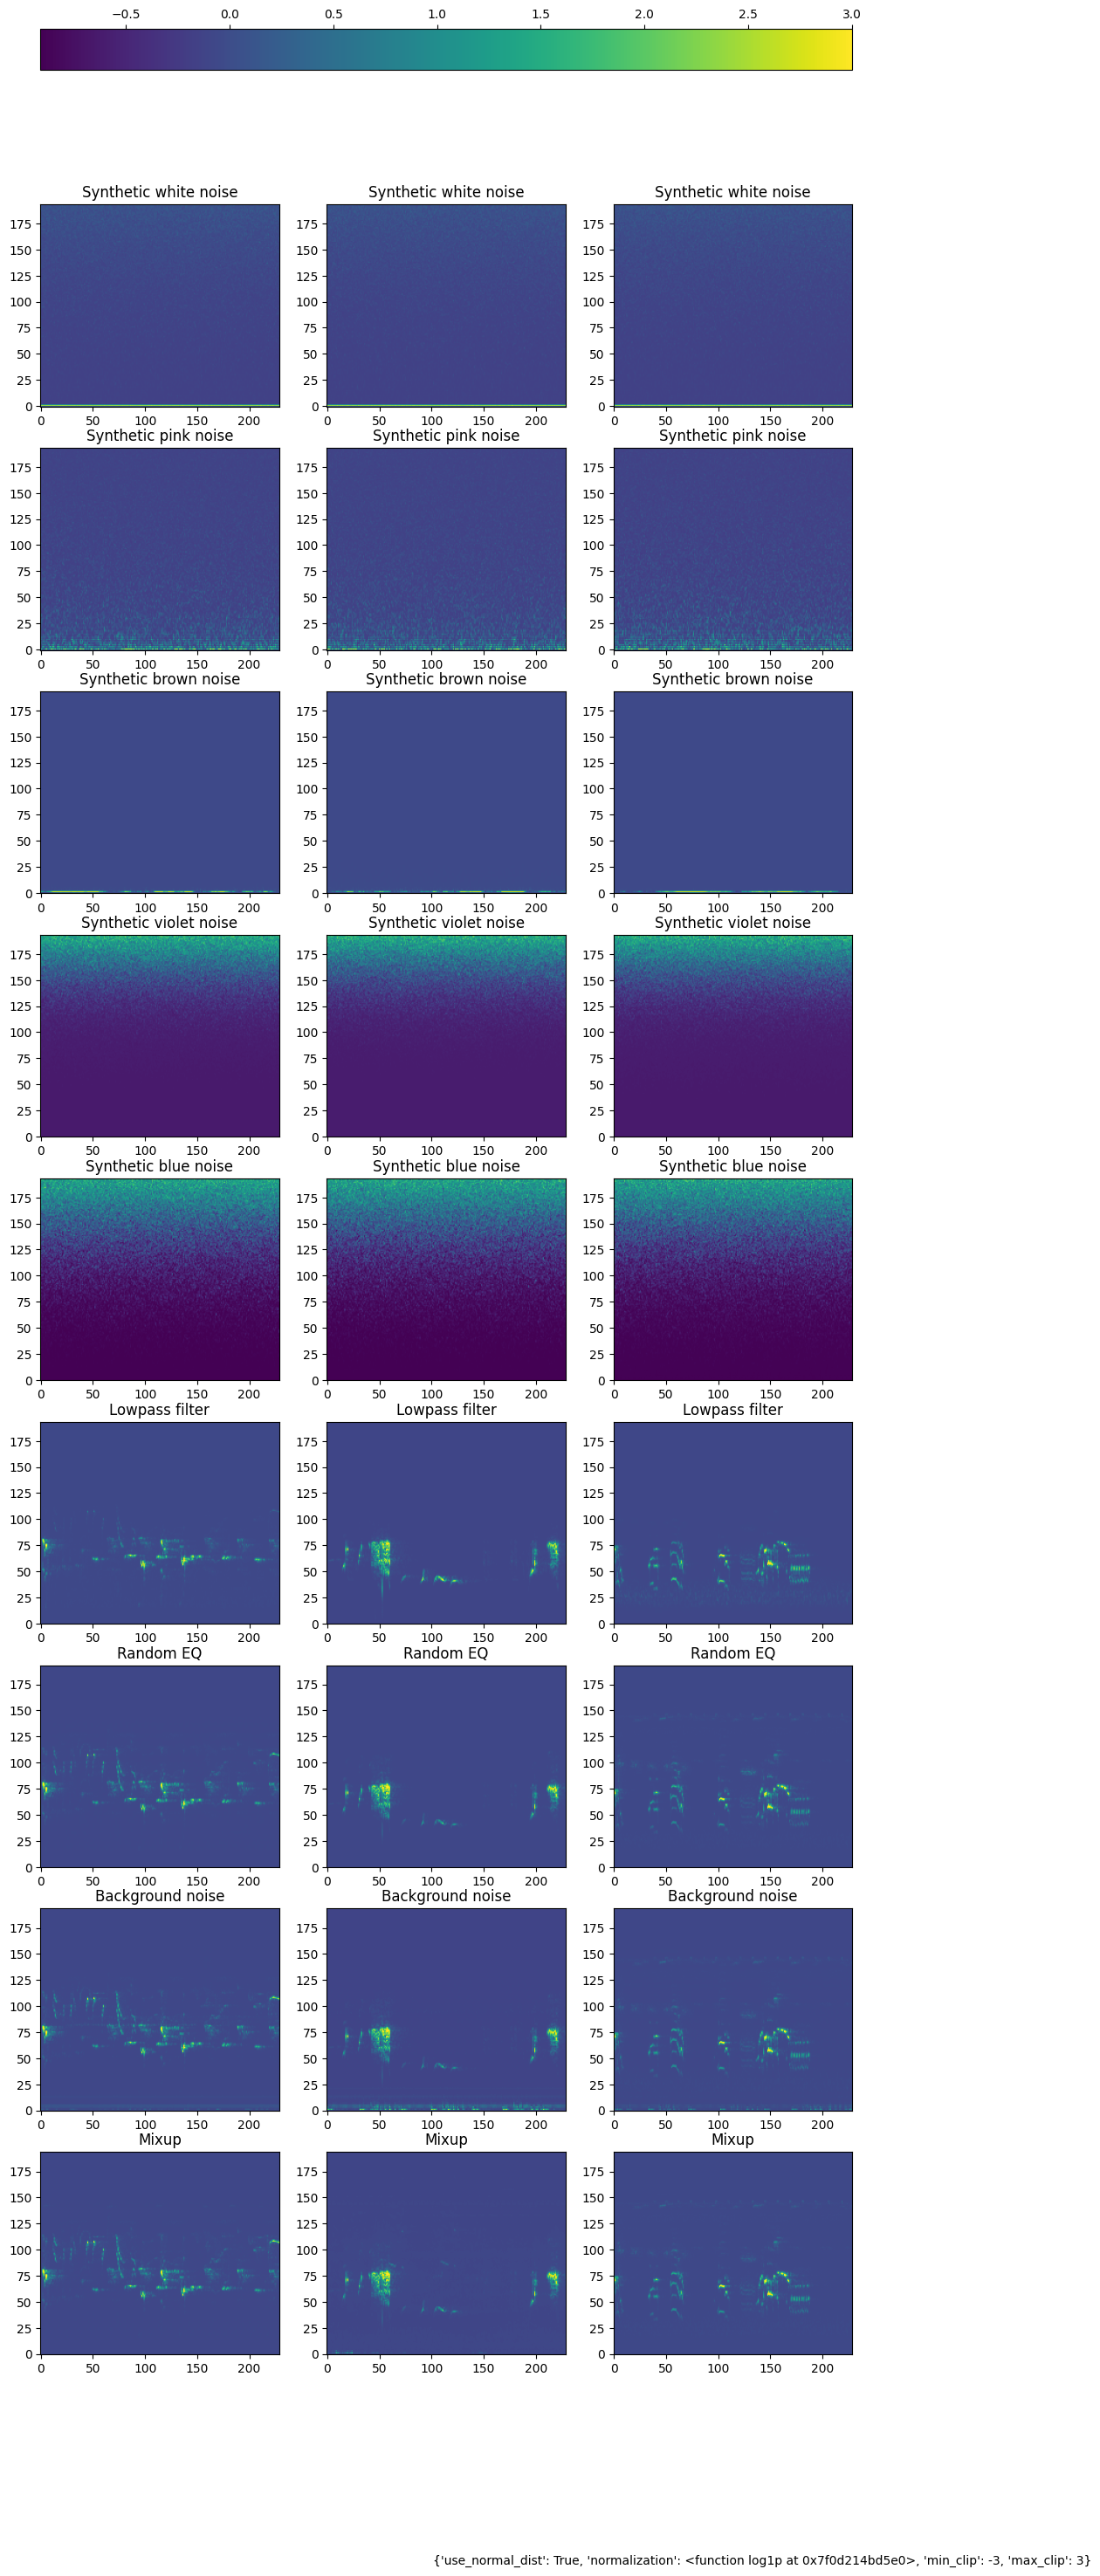

In [2]:
# PARAMETERS
CONF = {
    "synth_colors": ["white","pink","brown","violet","blue"],
    "synth_noise_intensity":  0.2,
    
    "lowpass_cutoff": 1000,
    "lowpass_q_val": 0.707,
    
    "eq_f_range": (100, 6000),
    "eq_g_range": (-8, 8),
    "eq_q_range": (1, 9),
    "eq_num_applications": 1,

    "background_intensity": 0.8,
    "background_norm": False,

    "mixup_alpha_range": (0.1,0.4),
}

def sigmoid(x): return 1 / (1 + np.exp(-x))
def linear(x): return x
def tanh(x): return np.tanh(x)
def log1p(x): return np.log1p(x)
NORMS = {
    "use_normal_dist": True,
    "normalization": log1p,
    "min_clip": -3,
    "max_clip": 3,
}


aug_viewer.main(n_samples=3, norms=NORMS, conf=CONF)